In [42]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet

### Part 1

In [3]:
file_path = "International_Report_Departures.csv"
df = pd.read_csv(file_path)
display(df) #visualisation without aggregation

,data_dte,Year,Month,usg_apt_id,usg_apt,usg_wac,fg_apt_id,fg_apt,fg_wac,airlineid,carrier,carriergroup,type,Scheduled,Charter,Total
0,05/01/2006,2006,5,12016,GUM,5,13162,MAJ,844,20177,PFQ,1,Departures,0,10,10
1,05/01/2003,2003,5,10299,ANC,1,13856,OKO,736,20007,5Y,1,Departures,0,15,15
2,03/01/2007,2007,3,10721,BOS,13,12651,KEF,439,20402,GL,1,Departures,0,1,1
3,12/01/2004,2004,12,11259,DAL,74,16271,YYZ,936,20201,AMQ,1,Departures,0,1,1
4,05/01/2009,2009,5,13303,MIA,33,11075,CMW,219,21323,5L,0,Departures,0,20,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930803,07/01/2000,2000,7,13303,MIA,33,13605,NAS,204,20398,MQ,1,Departures,1422,0,1422
930804,04/01/2019,2019,4,13303,MIA,33,14286,PTY,162,19770,CM,0,Departures,1439,0,1439
930805,08/01/2000,2000,8,13303,MIA,33,13605,NAS,204,20398,MQ,1,Departures,1441,0,1441
930806,09/01/2004,2004,9,12266,IAH,74,15632,VSA,148,19534,AM,0,Departures,1461,0,1461


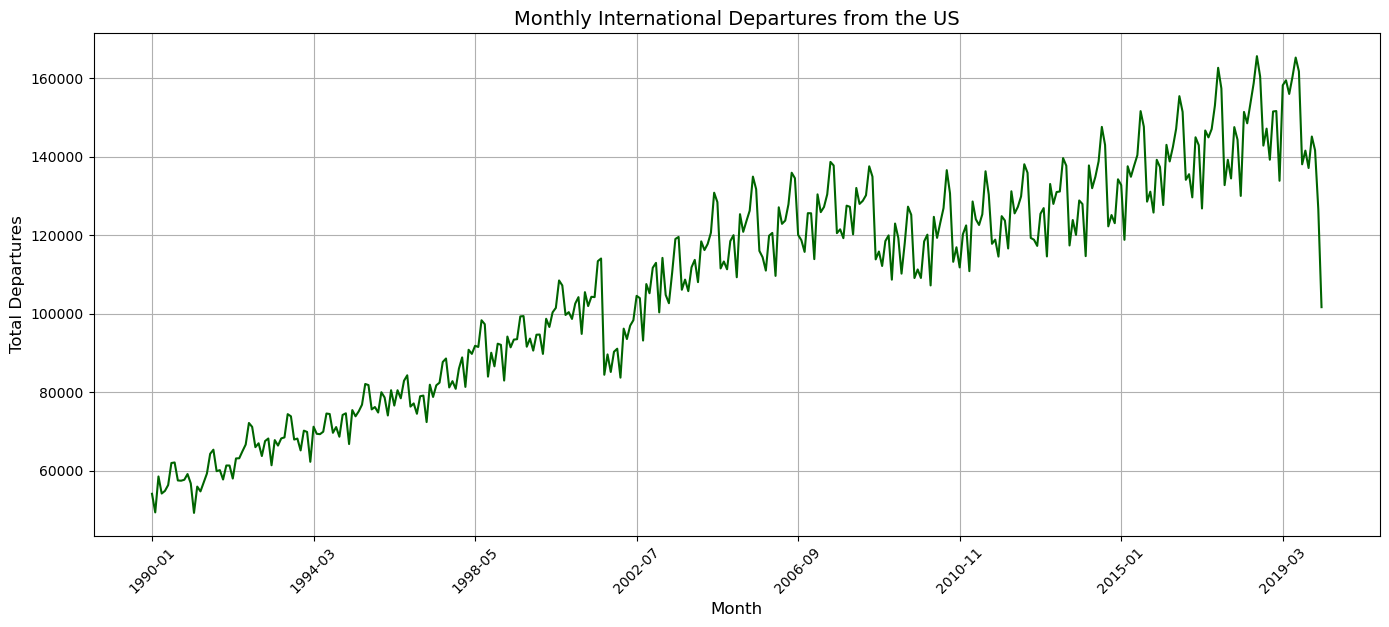

In [10]:
# Convert date column to datetime
df['data_dte'] = pd.to_datetime(df['data_dte'])

# Create a year-month column
df['year_month'] = df['data_dte'].dt.to_period('M')

# Aggregate by month: sum total departures
monthly_departures = df.groupby('year_month')['Total'].sum()

# Convert the index to string for readable axis labels
monthly_departures.index = monthly_departures.index.astype(str)

# Plotting the graph
plt.figure(figsize=(14, 6))
monthly_departures.plot(color='darkgreen')
plt.title("Monthly International Departures from the US", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Total Departures", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

Text(0, 0.5, 'Total Departures')

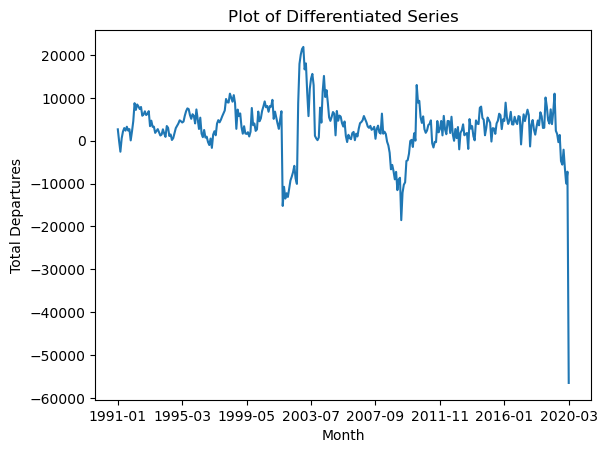

In [12]:
#Substract seasonality by using differncing
data_without_seasonality = monthly_departures.diff(periods=12)
data_without_seasonality = data_without_seasonality.dropna()
#Plot the transformed data
data_without_seasonality.plot()
plt.title("Plot of Differentiated Series")
plt.xlabel("Month")
plt.ylabel("Total Departures")

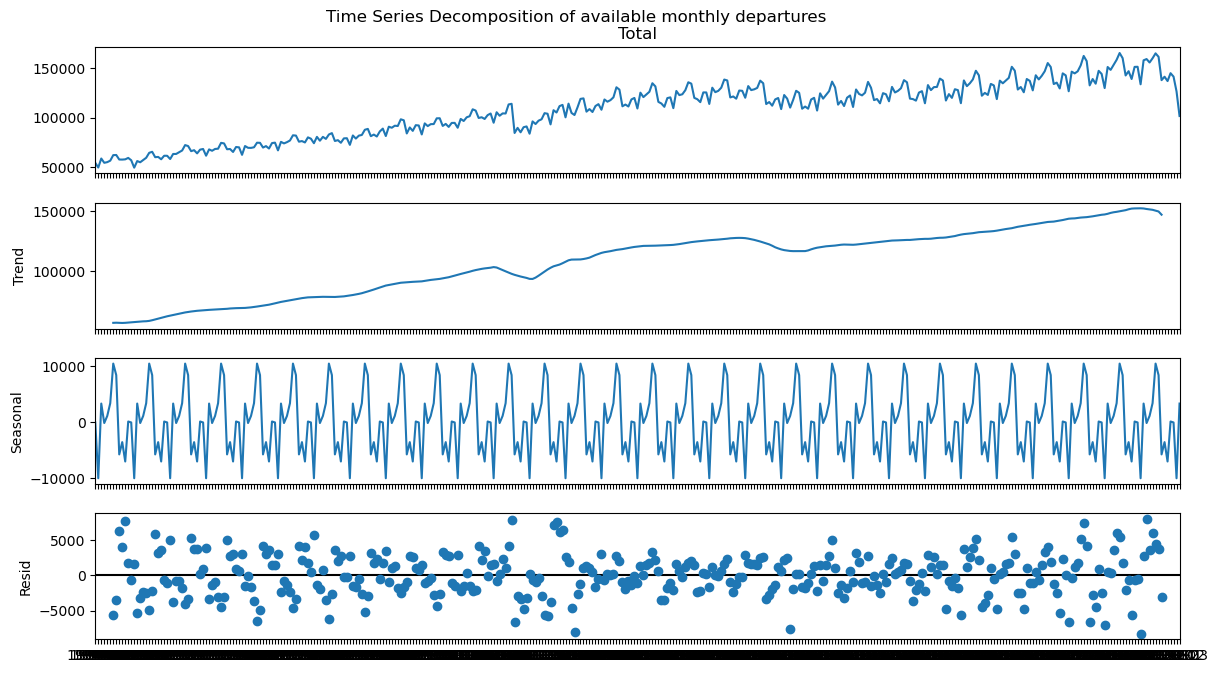

In [13]:
# Decompose the time series into trend, seasonal, and residual components
decomposition = seasonal_decompose(monthly_departures, model='additive', period=12)

# Plot the decomposed components
fig = decomposition.plot()
fig.set_size_inches(14, 7)
plt.suptitle('Time Series Decomposition of available monthly departures')
plt.show()

### Part 2

#### first we start with sarima models:

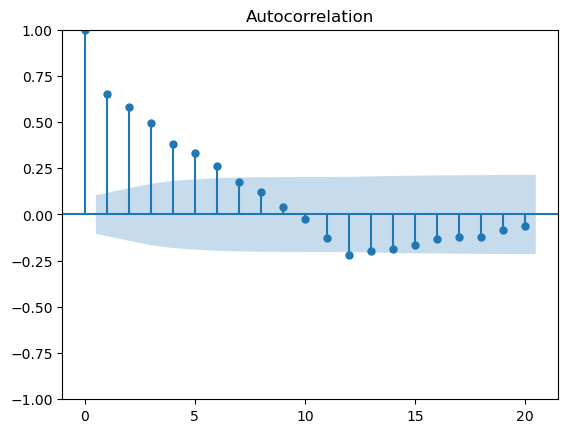

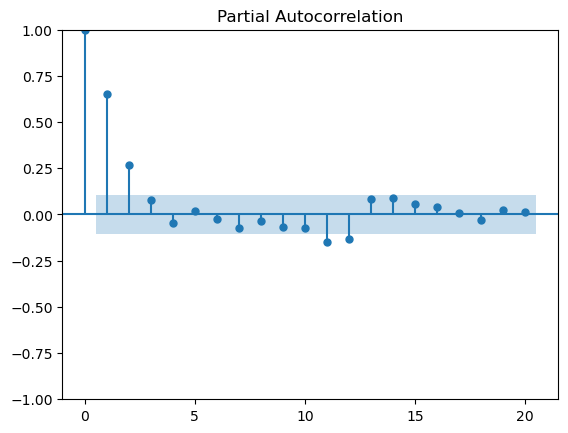

In [17]:
#Plotting the autocorrelation for the new series
tsaplots.plot_acf(data_without_seasonality, lags=20)
tsaplots.plot_pacf(data_without_seasonality, lags=20)
plt.show()

The model looks like AR(1) or equivalent to SARIMA(1,0,0)(0,1,0)_12. That because the Autocorrelation gradually decreases over time in a geometric decay pattern, which is typical for an AR(1) process. Also Partial Autocorrelation shows a significant spike at lag 2 and then cuts off sharply, so AR(2) is more likely. Another option is SARIMA(1,0,0)(1,1,0)_12 because the PACF acts like the AR's PACF. Also we can see a peak at t=11 and 12, that implies that maybe there is also AR seasonality.
In conclusion we will check: SARIMA(p,0,0)(0,1,0)_12 and SARIMA(p,0,0)(1,1,0)_12 for p=1,2


In [19]:
#SARIMA(1,0,0)(0,1,0)_{s=12}
model_AR1 = SARIMAX(monthly_departures, order=(1,0,0), seasonal_order=(0,1,0,12))
model_AR1 = model_AR1.fit(disp=False)

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [20]:
#SARIMA(1,0,0)(1,1,0)_{s=12}
model_AR1s = SARIMAX(monthly_departures, order=(1,0,0), seasonal_order=(1,1,0,12))
model_AR1s = model_AR1s.fit(disp=False)

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [21]:
#SARIMA(2,0,0)(0,1,0)_{s=12}
model_AR2 = SARIMAX(monthly_departures, order=(2,0,0), seasonal_order=(0,1,0,12))
model_AR2 = model_AR2.fit(disp=False)

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [22]:
#SARIMA(2,0,0)(1,1,0)_{s=12}
model_AR2s = SARIMAX(monthly_departures, order=(2,0,0), seasonal_order=(1,1,0,12))
model_AR2s = model_AR2s.fit(disp=False)

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [23]:
#Check the models BICs
print(f'Model AR1 BIC is : {model_AR1.bic}')
print(f'Model AR1s BIC is : {model_AR1s.bic}')
print(f'Model AR2 BIC is : {model_AR2.bic}')
print(f'Model AR2s BIC is : {model_AR2s.bic}')

Model AR1 BIC is : 6941.8338616524625
Model AR1s BIC is : 6894.773305865163
Model AR2 BIC is : 6947.446536773032
Model AR2s BIC is : 6893.540203480104


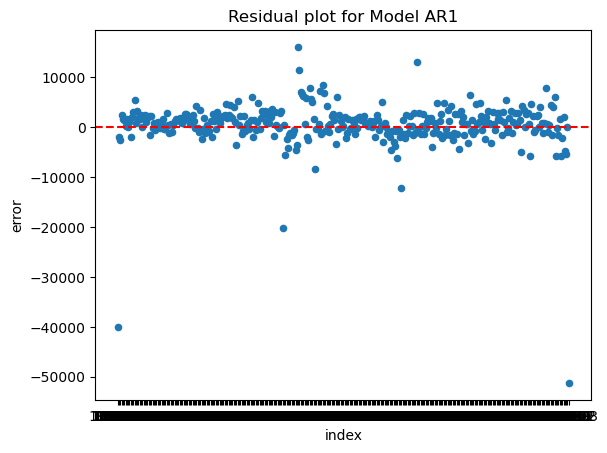

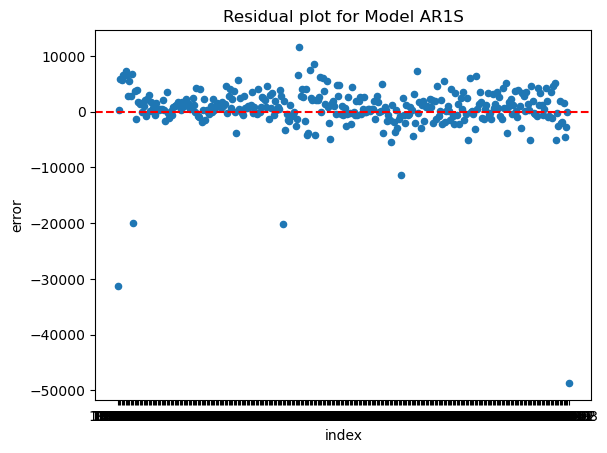

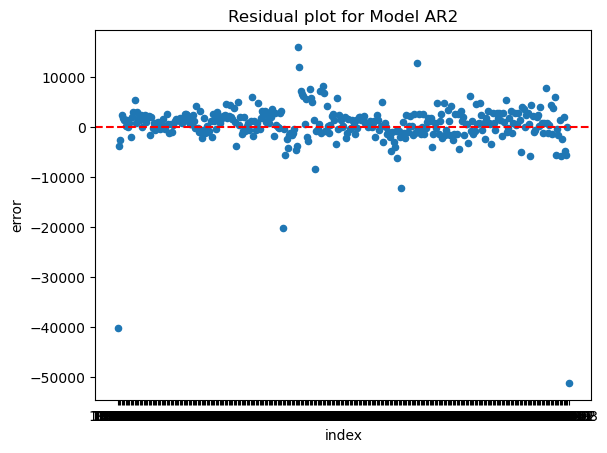

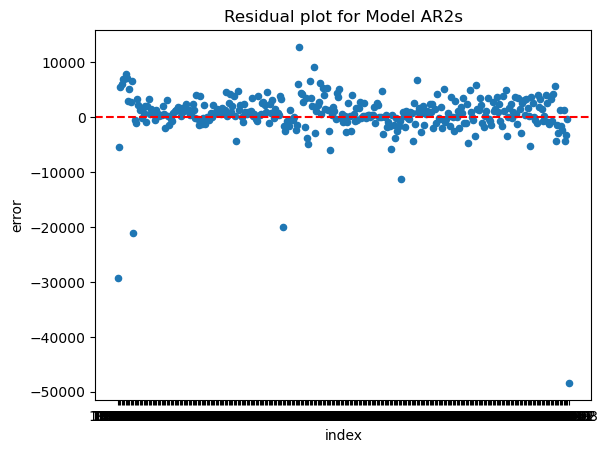

In [33]:
#Plot residual plots for every model


#Model AR1
res_plot = pd.DataFrame(model_AR1.resid.iloc[12:], columns = ['error'])
res_plot['index'] = res_plot.index
res_plot.plot.scatter(x='index', y="error")
plt.axhline(y=0, color="red", linestyle="--")
plt.title("Residual plot for Model AR1")
plt.show()

#Model AR1S
res_plot = pd.DataFrame(model_AR1s.resid.iloc[12:], columns = ['error'])
res_plot['index'] = res_plot.index
res_plot.plot.scatter(x='index', y="error")
plt.axhline(y=0, color="red", linestyle="--")
plt.title("Residual plot for Model AR1S")
plt.show()

#Model AR2
res_plot = pd.DataFrame(model_AR2.resid.iloc[12:], columns = ['error'])
res_plot['index'] = res_plot.index
res_plot.plot.scatter(x='index', y="error")
plt.axhline(y=0, color="red", linestyle="--")
plt.title("Residual plot for Model AR2")
plt.show()

#Model AR2s
res_plot = pd.DataFrame(model_AR2s.resid.iloc[12:], columns = ['error'])
res_plot['index'] = res_plot.index
res_plot.plot.scatter(x='index', y="error")
plt.axhline(y=0, color="red", linestyle="--")
plt.title("Residual plot for Model AR2s")
plt.show()

As we can see, the fourth model SARIMA(2,0,0)(1,1,0)_{s=12} , is a better fit and it has a lower BIC.All the models have pretty much the same residuals , so we will choose SARIMA(2,0,0)(1,1,0)_{s=12} as the best model.

In [37]:
print(model_AR2s.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Total   No. Observations:                  363
Model:             SARIMAX(2, 0, 0)x(1, 1, 0, 12)   Log Likelihood               -3435.049
Date:                            Fri, 28 Mar 2025   AIC                           6878.097
Time:                                    20:21:38   BIC                           6893.540
Sample:                                01-01-1990   HQIC                          6884.243
                                     - 03-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6786      0.060     11.316      0.000       0.561       0.796
ar.L2          0.1610      0.062   

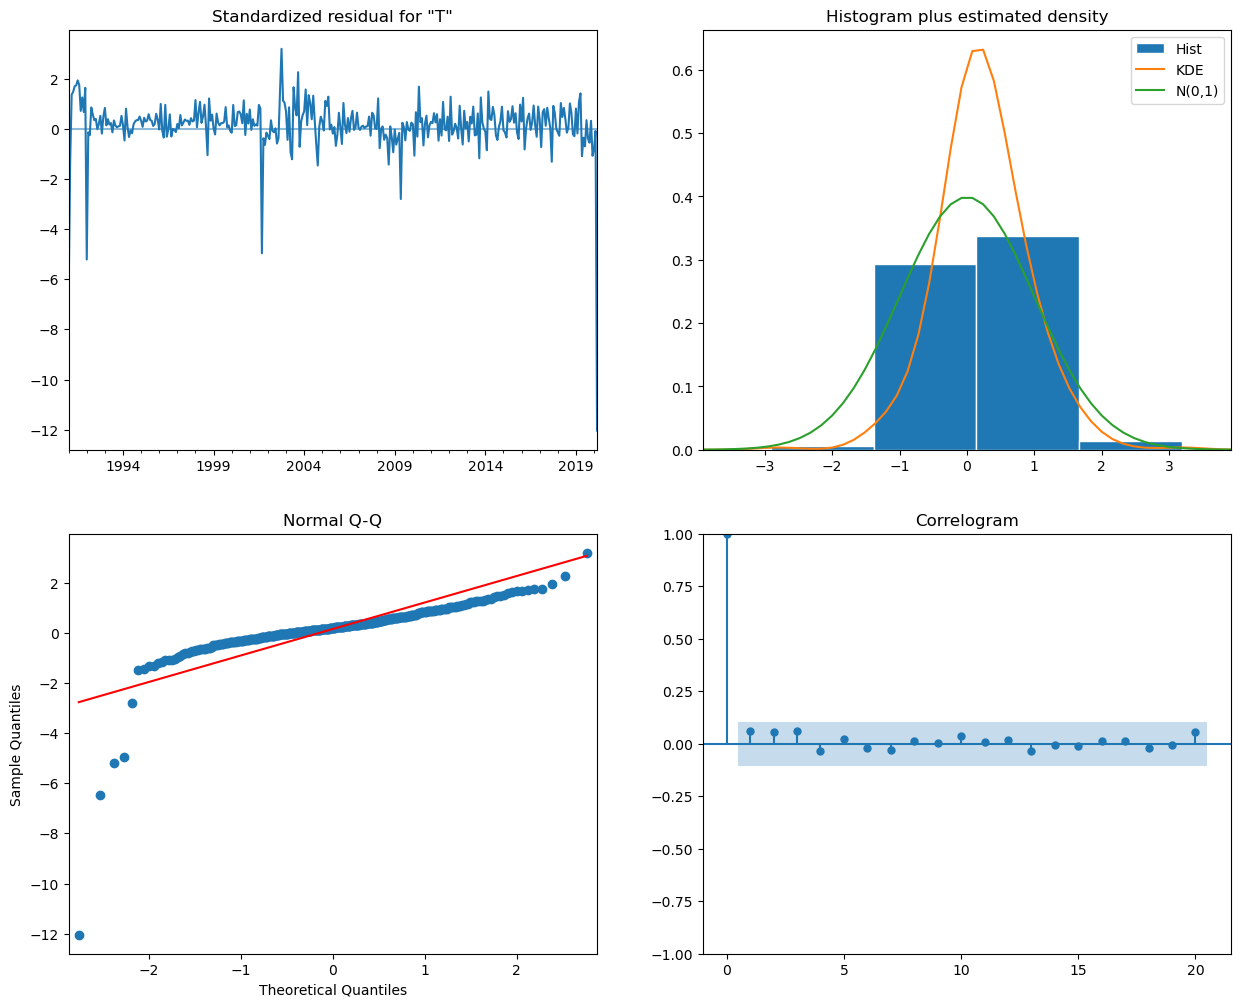

In [39]:
#Plot diagnostics
model_AR2s.plot_diagnostics(lags=20,figsize=(15, 12))
plt.show()

It's a good fit because in the QQ plot the dots  align with the line. Also, in the histogram the KDE fit very well the normal distrebution. 

#### we will try to fit propthet model:

In [49]:
df_prophet = monthly_departures.reset_index()
df_prophet.columns = ['ds', 'y']

df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

print(df_prophet.head())

          ds      y
0 1990-01-01  54129
1 1990-02-01  49391
2 1990-03-01  58542
3 1990-04-01  54195
4 1990-05-01  54863


In [51]:
model_p = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True)
model_p.fit(df_prophet)

21:59:29 - cmdstanpy - INFO - Chain [1] start processing
21:59:29 - cmdstanpy - INFO - Chain [1] done processing
